In [13]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, module_path)

import note.base as base
sys.path.pop(0)

SEED = 42
base.fix_seed(SEED)

In [33]:
import pandas as pd
from sklearn.metrics import classification_report

def df_comp_pred_result(df):

    df_cano_class_summary = pd.DataFrame(columns=['Subclass','total', 'model_correct','model_mis', 'canopus_correct','canopus_mis','canopus_nan'])
    subclasslist = df['correct_sub'].unique()

    for i in subclasslist:
        dfi = df[df['correct_sub'] == i]
        total = len(dfi)
        model_correct = len(dfi[dfi['me2lipid_sub'] == i])
        model_mis = len(dfi[dfi['me2lipid_sub'] != i])
        canopus_correct = len(dfi[dfi['canopus_sub'] == i])
        canopus_nan = len(dfi[dfi['canopus_sub'].isna()])
        canopus_mis = total - canopus_correct - canopus_nan

        new_row = {'Subclass': i,
                'total':total,
                'model_correct': model_correct,
                'model_mis': model_mis,
                'canopus_correct': canopus_correct,
                'canopus_mis':canopus_mis,
                'canopus_nan':canopus_nan}

        df_cano_class_summary = pd.concat([df_cano_class_summary, pd.DataFrame([new_row])], ignore_index=True)

    return df_cano_class_summary


def make_classification_reports(df_comp, excel_file_path):
    valid_labels = df_comp['correct_sub'].unique()
    canopus_report = classification_report(df_comp['correct_sub'], df_comp['canopus_sub'], labels=valid_labels,output_dict=True, zero_division=0)
    model_report = classification_report(df_comp['correct_sub'], df_comp['me2lipid_sub'], labels=valid_labels,output_dict=True, zero_division=0)

    excel_file = excel_file_path
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        pd.DataFrame(canopus_report).transpose().to_excel(writer, sheet_name='Canopus Report')
        pd.DataFrame(model_report).transpose().to_excel(writer, sheet_name='Model Report')

pos

In [46]:
import pandas as pd
df_pos2x = pd.read_csv('../../data/basedata/df_pos_MCH.csv')

from sklearn.model_selection import train_test_split
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_pos2x.drop(columns=columns_to_drop).astype(float).values
y = df_pos2x['Ontology']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
pos_indexid_path = '../../data/canopus/df_pos_indexid.csv'
pos_test_res_path = '../../data/model_comp/pos_pred_result/df_pos_result_random.csv'
select_ont_path = '../../data/canopus/subclass_ont_select_pos.csv'
canopus_result_path = '../../data/canopus/canopus_compound_summary_pos.tsv'

df_pos_indexid = pd.read_csv(pos_indexid_path)
df_pos_test_res = pd.read_csv(pos_test_res_path)
select_ont = pd.read_csv(select_ont_path)

df_test_pos = df_pos2x.loc[y_test.index].reindex(y_test.index)
df_test_pos = df_test_pos[columns_to_drop].\
    merge(df_pos_indexid[columns_to_drop].reset_index().rename(columns={'index':'index_id'}), on=columns_to_drop, how='inner').\
    merge(df_pos_test_res[['pred1st']], left_index=True, right_index=True).drop(columns=['Metabolitename', 'dataset', 'AlignmentID', 'AverageMz'])

df_test_pos = df_test_pos[df_test_pos['Ontology'].isin(select_ont.Ontology.tolist())].\
    merge(select_ont.rename(columns={'subclass':'correct_sub'}), how='left', on='Ontology').\
    merge(select_ont.rename(columns={'subclass':'me2lipid_sub', 'Ontology':'pred1st'}), how='left', on='pred1st')

df_canopus = pd.read_csv(canopus_result_path, sep="\t")
df_canopus['index_id'] = df_canopus['id'].apply(lambda x: x.split("_")[1])
df_canopus_ = df_canopus[['ClassyFire#subclass','index_id']].rename(columns={'ClassyFire#subclass':'canopus_sub'})
df_canopus_['index_id'] = df_canopus_['index_id'].astype(int)

df_canopus_sel = df_canopus_[df_canopus_['index_id'].isin(df_test_pos['index_id'].tolist())]

df_test_pos = df_test_pos.merge(df_canopus_sel, how='left', on='index_id')

In [48]:
subclasslist = ['Monoradylglycerols', 'Ceramides', 'Diradylglycerols',
 'Triradylglycerols', 'Phosphosphingolipids', 'Glycosphingolipids',
 'Glycerophosphoethanolamines', 'Glycerophosphoglycerols']

df_pos_comp = df_test_pos[df_test_pos['correct_sub'].isin(subclasslist)]

df_pos_cano_class_summary = df_comp_pred_result(df_pos_comp)

excel_file_path = '../../data/canopus/classification_reports_pos.xlsx'
make_classification_reports(df_pos_comp.astype(str), excel_file_path)

In [49]:
df_pos_comp_pred = df_pos_comp[~df_pos_comp['canopus_sub'].isna()]
excel_file_path = '../../data/canopus/classification_reports_pos_pred.xlsx'
make_classification_reports(df_pos_comp_pred.astype(str), excel_file_path)

In [50]:
df_pos_cano_class_summary.drop(columns='Subclass').sum()

total              1082
model_correct      1068
model_mis            14
canopus_correct      45
canopus_mis          31
canopus_nan        1006
dtype: object

neg

In [51]:
import pandas as pd
df_neg2x = pd.read_csv('../../data/basedata/df_neg_MCH.csv')

from sklearn.model_selection import train_test_split
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_neg2x.drop(columns=columns_to_drop).astype(float).values
y = df_neg2x['Ontology']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
neg_indexid_path = '../../data/canopus/df_neg_indexid.csv'
neg_test_res_path = '../../data/model_comp/neg_pred_result/df_neg_result_random.csv'
select_ont_path = '../../data/canopus/subclass_ont_select_neg.csv'
canopus_result_path = '../../data/canopus/canopus_compound_summary_neg.tsv'

df_neg_indexid = pd.read_csv(neg_indexid_path)
df_neg_test_res = pd.read_csv(neg_test_res_path).rename(columns={'Unnamed: 0':'ID'})
select_ont = pd.read_csv(select_ont_path)

df_test_neg = df_neg2x.loc[y_test.index].reindex(y_test.index)

df_test_neg = df_test_neg[columns_to_drop].reset_index().rename(columns={'index':'ID'}).\
    merge(df_neg_indexid[columns_to_drop].reset_index().rename(columns={'index':'index_id'}), on=columns_to_drop, how='inner').\
    merge(df_neg_test_res[['ID', 'pred1st']], on='ID', how='inner').drop(columns=['Metabolitename', 'dataset', 'AlignmentID', 'AverageMz'])

df_test_neg = df_test_neg[df_test_neg['Ontology'].isin(select_ont.Ontology.tolist())].\
    merge(select_ont.rename(columns={'subclass':'correct_sub'}), how='left', on='Ontology').\
    merge(select_ont.rename(columns={'subclass':'me2lipid_sub', 'Ontology':'pred1st'}), how='left', on='pred1st')

df_canopus = pd.read_csv(canopus_result_path, sep="\t")
df_canopus['index_id'] = df_canopus['id'].apply(lambda x: x.split("_")[1])
df_canopus_ = df_canopus[['ClassyFire#subclass','index_id']].rename(columns={'ClassyFire#subclass':'canopus_sub'})
df_canopus_['index_id'] = df_canopus_['index_id'].astype(int)

df_canopus_sel = df_canopus_[df_canopus_['index_id'].isin(df_test_neg['index_id'].tolist())]

df_test_neg = df_test_neg.merge(df_canopus_sel, how='left', on='index_id')

In [53]:
df_neg_comp = df_test_neg.copy()

df_neg_cano_class_summary = df_comp_pred_result(df_neg_comp)

excel_file_path = '../../data/canopus/classification_reports_neg.xlsx'
make_classification_reports(df_neg_comp.astype(str), excel_file_path)

In [54]:
df_neg_comp_pred = df_neg_comp[~df_neg_comp['canopus_sub'].isna()]
excel_file_path = '../../data/canopus/classification_reports_neg_pred.xlsx'
make_classification_reports(df_neg_comp_pred.astype(str), excel_file_path)

In [55]:
df_neg_cano_class_summary.drop(columns='Subclass').sum()

total              1442
model_correct      1430
model_mis            12
canopus_correct     761
canopus_mis         141
canopus_nan         540
dtype: object

plot

In [241]:
import matplotlib.pyplot as plt
import numpy as np

In [242]:
def calc_percent(df_cano_class_pred):
    df_all = df_cano_class_pred.rename(columns={'Subclass':'class'}).set_index('class')

    df_all_2 = pd.DataFrame()
    df_all_2['model_correct'] = (df_all['model_correct']/df_all['total'])*100
    df_all_2['model_mispred'] = 100-df_all_2['model_correct']

    df_all_2['canopus_correct'] = (df_all['canopus_correct']/df_all['total'])*100
    df_all_2['canopus_mispred'] = (df_all['canopus_mis']/df_all['total'])*100
    df_all_2['canopus_nonpred'] = (df_all['canopus_nan']/df_all['total'])*100

    df_all2 = df_all_2.reset_index().sort_values('class')

    return df_all, df_all2

/tmp/ipykernel_1473203/3680972731.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  correct_patch = mpatches.Patch(color=red, label='Correct', edgecolor='black')
/tmp/ipykernel_1473203/3680972731.py:95: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  incorrect_patch = mpatches.Patch(color=blue, label='Incorrect', edgecolor='black')
/tmp/ipykernel_1473203/3680972731.py:96: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  no_result_patch = mpatches.Patch(color=black, label='No result generated', edgecolor='black')


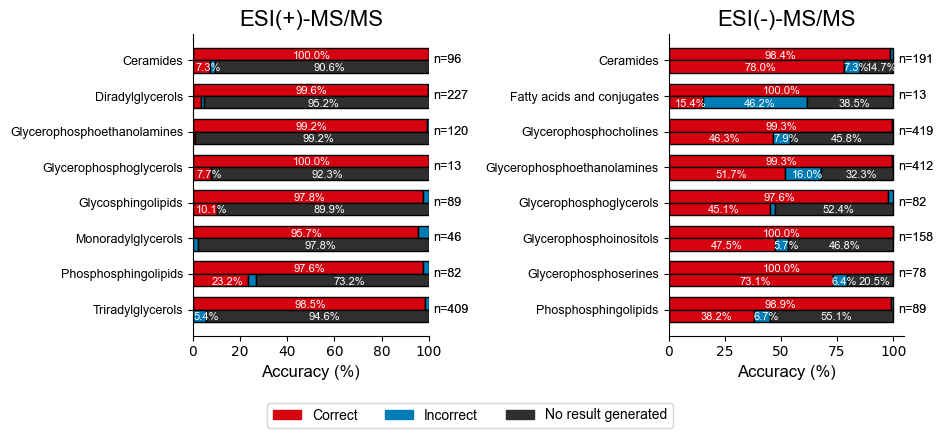

In [247]:
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm

save_fig_path = '../../data/canopus/canopus_res.svg'

arial_path = '../../arial.ttf'
arial = fm.FontProperties(fname=arial_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5,4))

df_neg_all, df_neg_plot = calc_percent(df_neg_cano_class_summary)
df_pos_all, df_pos_plot = calc_percent(df_pos_cano_class_summary)


width = 0.35  # バーの幅
y = np.arange(len(df_neg_plot['class']))  # Y軸のクラス

red = '#d50310'
blue = '#007cb6'
black = '#2f2f2f'
custom_colors = [red, blue, black]

# ax1: df_neg_plotを描画
ax1.barh(y - width / 2, df_pos_plot['model_correct'], width, label='model_correct', color=custom_colors[0], edgecolor='black')
ax1.barh(y - width / 2, df_pos_plot['model_mispred'], width, label='model_mispred', color=custom_colors[1], left=df_pos_plot['model_correct'], edgecolor='black')
ax1.barh(y + width / 2, df_pos_plot['canopus_correct'], width, label='canopus_correct', color=custom_colors[0], edgecolor='black')
ax1.barh(y + width / 2, df_pos_plot['canopus_mispred'], width, label='canopus_mispred', color=custom_colors[1], left=df_pos_plot['canopus_correct'], edgecolor='black')
ax1.barh(y + width / 2, df_pos_plot['canopus_nonpred'], width, label='canopus_nonpred', color=custom_colors[2], left=df_pos_plot['canopus_correct'] + df_pos_plot['canopus_mispred'], edgecolor='black')

ax1.set_yticks(y)
ax1.set_yticklabels(df_pos_plot['class'], fontproperties=arial, fontsize=9)
ax1.set_title('ESI(+)-MS/MS', fontproperties=arial, fontsize=16)
ax1.set_xlabel('Accuracy (%)', fontproperties=arial, fontsize=12)

bars1_pos= df_pos_plot[['model_correct','model_mispred']]
bars2_pos= df_pos_plot[['canopus_correct','canopus_mispred','canopus_nonpred']]

for n in bars1_pos:
    for i, (cs, ab, pc, sn) in enumerate(zip(bars1_pos.iloc[:, 0:].cumsum(1)[n],
                                        bars1_pos[n], bars1_pos[n],df_pos_all.sort_index()['total'])):
        if pc > 5.0:  
            ax1.text(cs - ab / 2 + 0.5, i - width/2 + 0.04, str(np.round(pc, 1)) + '%',
                    va='center', ha='center', rotation=0, fontsize=8, c='white', fontproperties=arial)
        ax1.text(100 + 2, i, f'n={sn}', va='center', ha='left', fontsize=9, alpha=0.8, c='black', fontproperties=arial)

for n in bars2_pos:
    for i, (cs, ab, pc) in enumerate(zip(bars2_pos.iloc[:, 0:].cumsum(1)[n],
                                        bars2_pos[n], bars2_pos[n])):
        if pc > 5.0:  
            ax1.text(cs - ab / 2 + 3, i + width/2 + 0.04, str(np.round(pc, 1)) + '%',
                    va='center', ha='center', rotation=0, fontsize=8, c='white', fontproperties=arial)
            
y = np.arange(len(df_neg_plot['class'])) 

ax2.barh(y - width / 2, df_neg_plot['model_correct'], width, label='model_correct', color=custom_colors[0], edgecolor='black')
ax2.barh(y - width / 2, df_neg_plot['model_mispred'], width, label='model_mispred', color=custom_colors[1], left=df_neg_plot['model_correct'], edgecolor='black')
ax2.barh(y + width / 2, df_neg_plot['canopus_correct'], width, label='canopus_correct', color=custom_colors[0], edgecolor='black')
ax2.barh(y + width / 2, df_neg_plot['canopus_mispred'], width, label='canopus_mispred', color=custom_colors[1], left=df_neg_plot['canopus_correct'], edgecolor='black')
ax2.barh(y + width / 2, df_neg_plot['canopus_nonpred'], width, label='canopus_nonpred', color=custom_colors[2], left=df_neg_plot['canopus_correct'] + df_neg_plot['canopus_mispred'], edgecolor='black')

ax2.set_yticks(y)
ax2.set_yticklabels(df_neg_plot['class'], fontproperties=arial, fontsize=9)
ax2.set_title('ESI(-)-MS/MS', fontproperties=arial, fontsize=16)
ax2.set_xlabel('Accuracy (%)', fontproperties=arial, fontsize=12)

bars1_neg= df_neg_plot[['model_correct','model_mispred']]
bars2_neg= df_neg_plot[['canopus_correct','canopus_mispred','canopus_nonpred']]

for n in bars1_neg:
    for i, (cs, ab, pc, sn) in enumerate(zip(bars1_neg.iloc[:, 0:].cumsum(1)[n],
                                        bars1_neg[n], bars1_neg[n],df_neg_all.sort_index()['total'])):
        if pc > 5.0:  
            ax2.text(cs - ab / 2 + 0.5, i - width/2 + 0.04, str(np.round(pc, 1)) + '%',
                    va='center', ha='center', rotation=0, fontsize=8, c='white', fontproperties=arial)
        ax2.text(100 + 2, i, f'n={sn}', va='center', ha='left', fontsize=9, alpha=0.8, c='black', fontproperties=arial)

for n in bars2_neg:
    for i, (cs, ab, pc) in enumerate(zip(bars2_neg.iloc[:, 0:].cumsum(1)[n],
                                        bars2_neg[n], bars2_neg[n])):
        if pc > 5.0:  
            ax2.text(cs - ab / 2 + 2, i + width/2 + 0.04, str(np.round(pc, 1)) + '%',
                    va='center', ha='center', rotation=0, fontsize=8, c='white', fontproperties=arial)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.invert_yaxis()  
correct_patch = mpatches.Patch(color=red, label='Correct', edgecolor='black')
incorrect_patch = mpatches.Patch(color=blue, label='Incorrect', edgecolor='black')
no_result_patch = mpatches.Patch(color=black, label='No result generated', edgecolor='black')

fig.legend(handles=[correct_patch, incorrect_patch, no_result_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, prop=arial)

plt.tight_layout()
plt.savefig(save_fig_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()